# SPRINT 3

Quins llindars de saldo podrien indicar més risc de
morositat?

In [68]:
import pymysql
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats

### CONEXIÓN

In [69]:
S3_df_BANK_marketing = pd.read_parquet('S3_df_BANK_marketing.parquet')
S3_df_BANK_marketing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26179 entries, 0 to 26178
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   26179 non-null  int64  
 1   age                  26179 non-null  float64
 2   job                  26179 non-null  object 
 3   marital              26179 non-null  object 
 4   education            26179 non-null  object 
 5   is_in_default        26179 non-null  float64
 6   balance              26179 non-null  int64  
 7   housing              26179 non-null  int32  
 8   loan                 26179 non-null  int64  
 9   contact              26179 non-null  object 
 10  day                  26179 non-null  int64  
 11  month                26179 non-null  object 
 12  duration             26179 non-null  int64  
 13  campaign             26179 non-null  int64  
 14  pdays                26179 non-null  int64  
 15  previous             26179 non-null 

In [70]:
print(S3_df_BANK_marketing.isnull().sum())
print(f"Los cantidad de duplicados es: {S3_df_BANK_marketing.duplicated().sum()}")


id                     0
age                    0
job                    0
marital                0
education              0
is_in_default          0
balance                0
housing                0
loan                   0
contact                0
day                    0
month                  0
duration               0
campaign               0
pdays                  0
previous               0
poutcome               0
deposit                0
balance_normalizado    0
estado_balance         0
dtype: int64
Los cantidad de duplicados es: 0


Seleccionamos las columnas que útiles para el departamento de finanzas

In [71]:
df_f = S3_df_BANK_marketing[['id','age','job','marital','education','is_in_default','balance','housing','loan','balance_normalizado','estado_balance']]
df_f.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26179 entries, 0 to 26178
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   26179 non-null  int64  
 1   age                  26179 non-null  float64
 2   job                  26179 non-null  object 
 3   marital              26179 non-null  object 
 4   education            26179 non-null  object 
 5   is_in_default        26179 non-null  float64
 6   balance              26179 non-null  int64  
 7   housing              26179 non-null  int32  
 8   loan                 26179 non-null  int64  
 9   balance_normalizado  26179 non-null  float64
 10  estado_balance       26179 non-null  object 
dtypes: float64(3), int32(1), int64(3), object(4)
memory usage: 2.1+ MB


In [72]:
df_f.head()

,id,age,job,marital,education,is_in_default,balance,housing,loan,balance_normalizado,estado_balance
0,1,59.0,admin.,married,secondary,0.0,2343,1,0,0.251390,Saldo Alto
1,2,59.0,admin.,married,secondary,0.0,2343,1,0,0.251390,Saldo Alto
2,3,56.0,admin.,married,secondary,0.0,45,0,0,-0.446981,Saldo Bajo
3,4,41.0,technician,married,secondary,0.0,1270,1,0,-0.074698,Saldo Medio Alto
4,5,55.0,services,married,secondary,0.0,2476,1,0,0.291810,Saldo Alto


In [73]:
df_f.describe()

,id,age,is_in_default,balance,housing,loan,balance_normalizado
count,26179.000000,26179.000000,26179.000000,26179.000000,26179.000000,26179.000000,2.617900e+04
mean,13170.265098,41.233546,0.015585,1515.796363,0.471523,0.130715,-2.849879e-17
std,7643.457481,11.887219,0.123866,3290.577468,0.499198,0.337095,1.000019e+00
min,1.000000,18.000000,0.000000,-6847.000000,0.000000,0.000000,-2.541486e+00
25%,6545.500000,32.000000,0.000000,121.000000,0.000000,0.000000,-4.238840e-01
50%,13090.000000,39.000000,0.000000,544.000000,0.000000,0.000000,-2.953326e-01
75%,19844.500000,49.000000,0.000000,1689.000000,1.000000,0.000000,5.263725e-02
max,26389.000000,95.000000,1.000000,81204.000000,1.000000,1.000000,2.421755e+01


Vemos la cantidad total de cada opción a analizar

In [74]:
print(df_f['is_in_default'].value_counts())

is_in_default
0.0    25771
1.0      408
Name: count, dtype: int64


Ordenamos la categoria estado_balance

In [75]:
estado_balance_order = ['Saldo Muy Alto', 'Saldo Alto', 'Saldo Medio Alto', 'Saldo Medio', 'Saldo Bajo', 'Saldo Muy Bajo']
df_f['estado_balance'] = pd.Categorical(df_f['estado_balance'], categories=estado_balance_order, ordered=True)

C:\Users\Adam\AppData\Local\Temp\ipykernel_14792\4283965127.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_f['estado_balance'] = pd.Categorical(df_f['estado_balance'], categories=estado_balance_order, ordered=True)


Observamos la cantidad de morosidad por categroia de balance

In [76]:
conteo = df_f.groupby('estado_balance')['is_in_default'].value_counts()
conteo

C:\Users\Adam\AppData\Local\Temp\ipykernel_14792\2467586623.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  conteo = df_f.groupby('estado_balance')['is_in_default'].value_counts()


estado_balance    is_in_default
Saldo Muy Alto    0.0              2459
                  1.0                 3
Saldo Alto        0.0              4081
                  1.0                 4
Saldo Medio Alto  0.0              6522
                  1.0                27
Saldo Medio       0.0              6503
                  1.0                44
Saldo Bajo        0.0              6199
                  1.0               329
Saldo Muy Bajo    0.0                 7
                  1.0                 1
Name: count, dtype: int64

### EDA

#### ANALISIS DESCRIPTIVO

In [77]:
df_f.groupby('is_in_default')['balance'].describe()


,count,mean,std,min,25%,50%,75%,max
is_in_default,,,,,,,,
0.0,25771.0,1540.344845,3309.264782,-3058.0,131.0,559.0,1716.00,81204.0
1.0,408.0,-34.789216,772.679081,-6847.0,-338.0,0.0,68.25,5249.0


El análisis de los datos de is_in_default revela diferencias significativas entre los clientes que están en morosidad y los que no lo están. En primer lugar, hay más clientes que no están en morosidad (13,843) en comparación con los que están en morosidad (12,336). Los saldos medios muestran una diferencia notable: los clientes que no están en morosidad tienen un saldo medio de 1,756.59, significativamente mayor que el saldo medio de 1,245.58 de los clientes en morosidad.

Además, la variabilidad del saldo es más alta en los clientes que no están en morosidad, con una desviación estándar de 3,866.06, frente a los 2,463.53 de los clientes en morosidad. Los clientes en morosidad tienen saldos máximos significativamente más bajos (45,248) comparados con los clientes que no están en morosidad (81,204). Los percentiles también reflejan esta tendencia: los clientes en morosidad tienen valores de saldo en los percentiles 25%, 50% y 75% más bajos en general.

A primera vista, los clientes en morosidad tienden a tener saldos más bajos y menos variabilidad en comparación con los clientes que no están en morosidad, lo que sugiere que los saldos más bajos están asociados con un mayor riesgo de morosidad.

- Vemos el porcentaje de is_in_default segun estado_balance

In [78]:
estado_balance_mean = df_f.groupby('estado_balance')['is_in_default'].mean()
estado_balance_mean_percent = (estado_balance_mean * 100).round(2)
estado_balance_mean_percent

C:\Users\Adam\AppData\Local\Temp\ipykernel_14792\2637152361.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  estado_balance_mean = df_f.groupby('estado_balance')['is_in_default'].mean()


estado_balance
Saldo Muy Alto       0.12
Saldo Alto           0.10
Saldo Medio Alto     0.41
Saldo Medio          0.67
Saldo Bajo           5.04
Saldo Muy Bajo      12.50
Name: is_in_default, dtype: float64

Los datos sugieren que los clientes con saldos más bajos (Saldo Muy Bajo y Saldo Bajo) tienen un riesgo significativamente mayor de estar en morosidad. A medida que el saldo disminuye, la proporción de clientes en impago aumenta notablemente. Por el contrario, los clientes con saldos altos y muy altos tienen un menor riesgo de morosidad. 

#### TESTS ESTADÍSTICOS

##### Test T y Prueba de U para is_in_default con balance

In [79]:
from scipy.stats import ttest_ind, mannwhitneyu

morosos = df_f[df_f['is_in_default'] == 1]['balance']
no_morosos = df_f[df_f['is_in_default'] == 0]['balance']

t_stat, t_p_value = ttest_ind(morosos, no_morosos, equal_var=False)
u_stat, u_p_value = mannwhitneyu(morosos, no_morosos)
print(f"T-Test p-value: {t_p_value}")
print(f"Mann-Whitney U p-value: {u_p_value}")


T-Test p-value: 1.0416921596077364e-160
Mann-Whitney U p-value: 9.855332429429326e-128


Estos resultados apoyan la hipótesis de que el saldo es un factor importante que puede estar relacionado con el riesgo de morosidad. En otras palabras, los saldos más bajos están asociados con una mayor probabilidad de morosidad, y esta relación es estadísticamente significativa.

Estos hallazgos refuerzan la importancia de considerar el saldo como un indicador clave del riesgo de impago al evaluar la solvencia de los clientes.

In [80]:
from scipy.stats import chi2_contingency

tabla_con = pd.crosstab(df_f['estado_balance'], df_f['is_in_default'])
chi2, p, dof, expected = chi2_contingency(tabla_con)
print(f"Chi2 Test p-value: {p}")


Chi2 Test p-value: 2.3696095851110265e-149


El resultado del test Chi-cuadrado sugiere que existe una relación estadísticamente significativa entre las categorías de saldo (estado_balance) y el estado de morosidad (is_in_default).

#### PRIMERAS VISUALIZACIONES

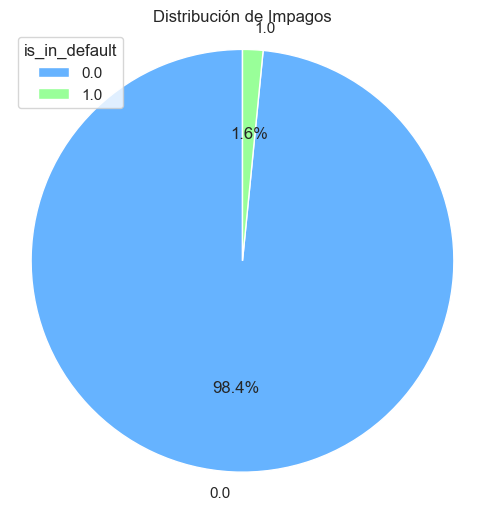

In [81]:
default_counts = df_f['is_in_default'].value_counts()

plt.figure(figsize=(6, 6))
plt.pie(default_counts, labels=default_counts.index, autopct='%1.1f%%', startangle=90, colors=['#66b3ff', '#99ff99'])
plt.title('Distribución de Impagos')
plt.legend(default_counts.index, title="is_in_default", loc="best")
plt.axis('equal')  
plt.show()

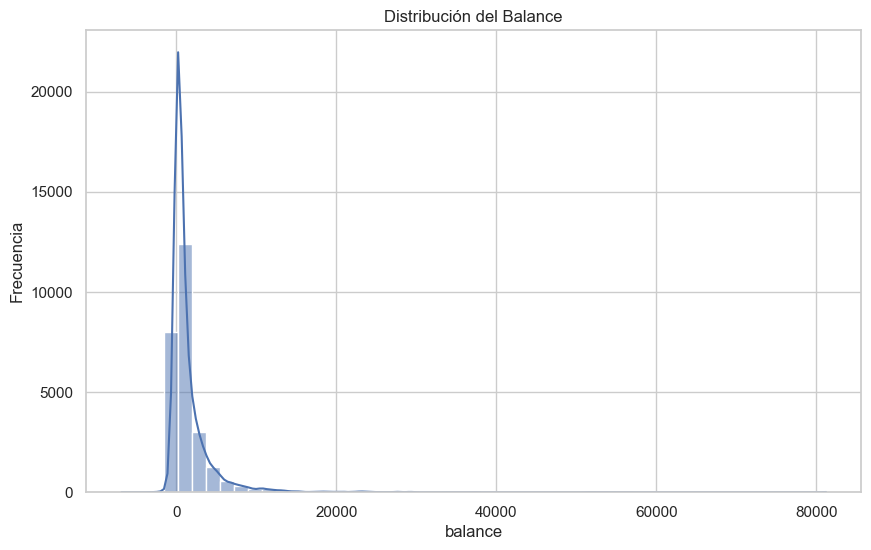

In [82]:
plt.figure(figsize=(10, 6))
sns.histplot(df_f['balance'], bins=50, kde=True)
plt.title('Distribución del Balance')
plt.xlabel('balance')
plt.ylabel('Frecuencia')
plt.show()

##### Histograma de la Distribución de Saldos por Estado de Morosidad

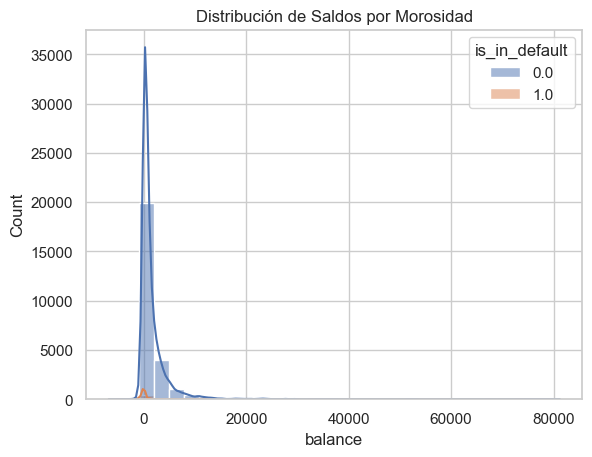

In [83]:
sns.histplot(data=df_f, x='balance', hue='is_in_default', kde=True, bins=30)
plt.title('Distribución de Saldos por Morosidad')
plt.show()



##### Boxplot del Balance por Estado de Morosidad

C:\Users\Adam\AppData\Local\Temp\ipykernel_14792\387162997.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='is_in_default', y='balance', data=df_f, palette='magma_r')


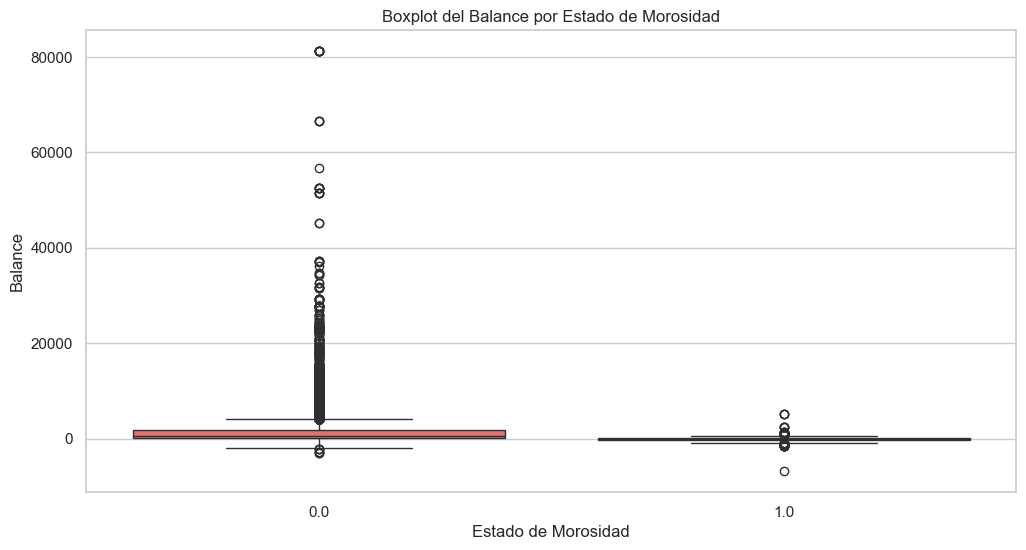

In [84]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='is_in_default', y='balance', data=df_f, palette='magma_r')
plt.title('Boxplot del Balance por Estado de Morosidad')
plt.xlabel('Estado de Morosidad')
plt.ylabel('Balance')
plt.show()



##### Riesgo de Morosidad por Categoría de Saldo

C:\Users\Adam\AppData\Local\Temp\ipykernel_14792\490524218.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  riesgo_categoria_balance = df_f.groupby('estado_balance')['is_in_default'].mean().reset_index()
C:\Users\Adam\AppData\Local\Temp\ipykernel_14792\490524218.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(data=riesgo_categoria_balance, x='estado_balance', y='is_in_default', palette='magma_r')


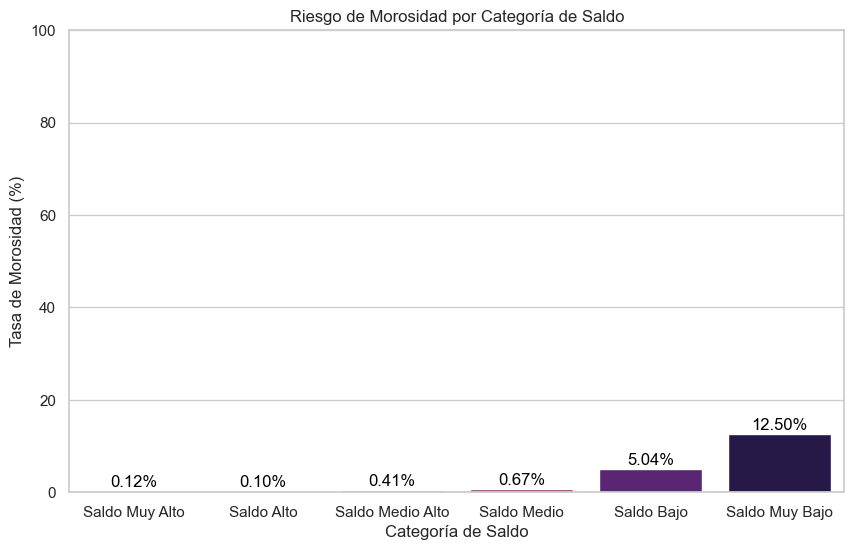

In [85]:
riesgo_categoria_balance = df_f.groupby('estado_balance')['is_in_default'].mean().reset_index()

# Convertir la tasa de morosidad a porcentaje
riesgo_categoria_balance['is_in_default'] = riesgo_categoria_balance['is_in_default'] * 100
plt.figure(figsize=(10, 6))
barplot = sns.barplot(data=riesgo_categoria_balance, x='estado_balance', y='is_in_default', palette='magma_r')

# Añadir los porcentajes sobre las barras
for index, row in riesgo_categoria_balance.iterrows():
    barplot.text(index, row['is_in_default'] + 1, f"{row['is_in_default']:.2f}%", color='black', ha="center")

plt.title('Riesgo de Morosidad por Categoría de Saldo')
plt.xlabel('Categoría de Saldo')
plt.ylabel('Tasa de Morosidad (%)')
plt.ylim(0, 100) 
plt.show()


##### Gráfico de Cuartiles de Saldos y Tasa de Morosidad

C:\Users\Adam\AppData\Local\Temp\ipykernel_14792\3079282862.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_f['balance_cuartiles'] = pd.qcut(df_f['balance'], 4, labels=['Q1', 'Q2', 'Q3', 'Q4'])
C:\Users\Adam\AppData\Local\Temp\ipykernel_14792\3079282862.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  riesgo_cuartiles = df_f.groupby('balance_cuartiles')['is_in_default'].mean() * 100


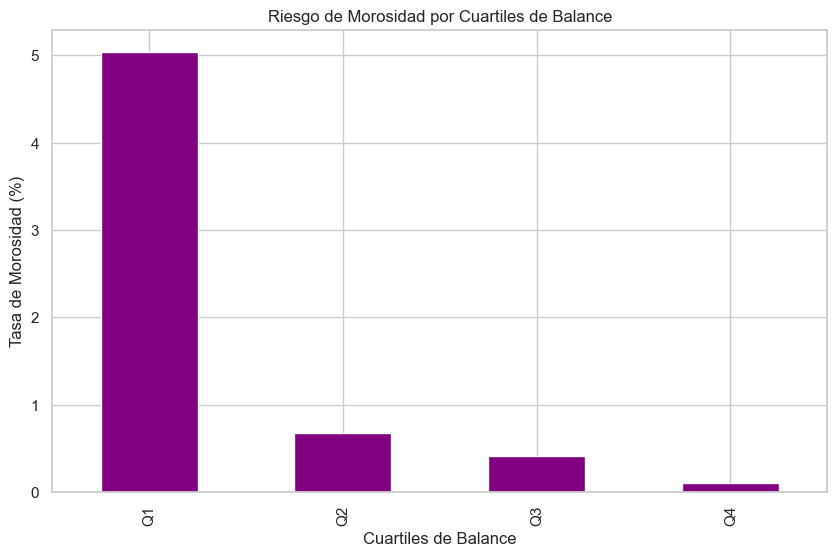

In [86]:
df_f['balance_cuartiles'] = pd.qcut(df_f['balance'], 4, labels=['Q1', 'Q2', 'Q3', 'Q4'])
riesgo_cuartiles = df_f.groupby('balance_cuartiles')['is_in_default'].mean() * 100

plt.figure(figsize=(10, 6))
riesgo_cuartiles.plot(kind='bar', color='purple')
plt.xlabel('Cuartiles de Balance')
plt.ylabel('Tasa de Morosidad (%)')
plt.title('Riesgo de Morosidad por Cuartiles de Balance')
plt.show()


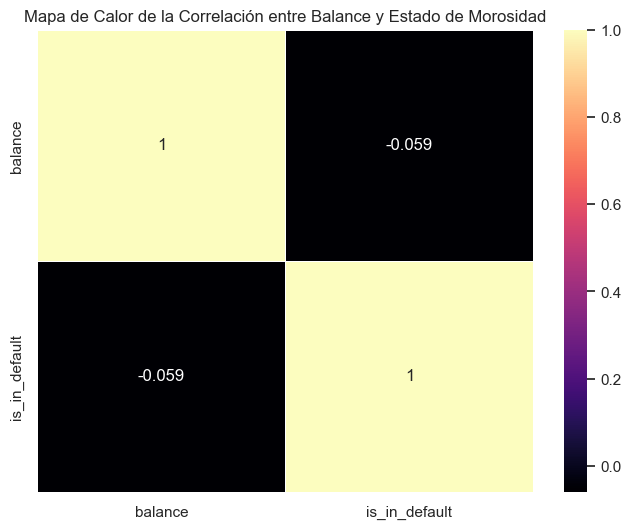

In [87]:
correlacion = df_f[['balance', 'is_in_default']].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlacion, annot=True, cmap='magma', linewidths=0.5)
plt.title('Mapa de Calor de la Correlación entre Balance y Estado de Morosidad')
plt.show()


# ANALISIS

In [88]:
df_f['balance'].mean().round(2)

1515.8

In [89]:
df_f['hipoteca_y_prestamo'].value_counts()

KeyError: 'hipoteca_y_prestamo'

##### Riesgo de impagos

In [ ]:
# Calcular la media del balance por categoría
mean_balance_loan = df_f.groupby('loan')['balance'].mean().round(2)
mean_balance_housing = df_f.groupby('housing')['balance'].mean().round(2)
mean_balance_both = df_f.groupby('hipoteca_y_prestamo')['balance'].mean().round(2)

# Calcular la cantidad de clientes por categoría
count_clients_loan = df_f.groupby('loan').size()
count_clients_housing = df_f.groupby('housing').size()
count_clients_both = df_f.groupby('hipoteca_y_prestamo').size()

# Calcular la cantidad de impagos (is_in_default = 1) por categoría
count_default_loan = df_f[df_f['is_in_default'] == 1].groupby('loan')['is_in_default'].count()
count_default_housing = df_f[df_f['is_in_default'] == 1].groupby('housing')['is_in_default'].count()
count_default_both = df_f[df_f['is_in_default'] == 1].groupby('hipoteca_y_prestamo')['is_in_default'].count()

# Calcular las tablas con porcentajes
crosstab_loan = (pd.crosstab(df_f['loan'], df_f['is_in_default'], normalize='index') * 100).round(2)
crosstab_housing = (pd.crosstab(df_f['housing'], df_f['is_in_default'], normalize='index') * 100).round(2)
crosstab_both = (pd.crosstab(df_f['hipoteca_y_prestamo'], df_f['is_in_default'], normalize='index') * 100).round(2)

# Añadir la media del balance
crosstab_loan['Media Balance'] = mean_balance_loan.values
crosstab_housing['Media Balance'] = mean_balance_housing.values
crosstab_both['Media Balance'] = mean_balance_both.values

# Añadir la cantidad de clientes y cantidad de impagos
crosstab_loan['Cantidad de Clientes'] = count_clients_loan.values
crosstab_housing['Cantidad de Clientes'] = count_clients_housing.values
crosstab_both['Cantidad de Clientes'] = count_clients_both.values

crosstab_loan['Impago'] = count_default_loan.reindex(crosstab_loan.index, fill_value=0).values
crosstab_housing['Impago'] = count_default_housing.reindex(crosstab_housing.index, fill_value=0).values
crosstab_both['Impago'] = count_default_both.reindex(crosstab_both.index, fill_value=0).values

# Renombrar columnas
crosstab_loan.rename(columns={0: 'Sin Impago (%)', 1: 'Con Impago (%)'}, inplace=True)
crosstab_housing.rename(columns={0: 'Sin Impago (%)', 1: 'Con Impago (%)'}, inplace=True)
crosstab_both.rename(columns={0: 'Sin Impago (%)', 1: 'Con Impago (%)'}, inplace=True)

# Reorganizar las columnas para que 'Media Balance' y 'Cantidad de Clientes' sean las primeras
crosstab_loan = crosstab_loan[['Media Balance', 'Cantidad de Clientes', 'Impago', 'Sin Impago (%)', 'Con Impago (%)']]
crosstab_housing = crosstab_housing[['Media Balance', 'Cantidad de Clientes', 'Impago', 'Sin Impago (%)', 'Con Impago (%)']]
crosstab_both = crosstab_both[['Media Balance', 'Cantidad de Clientes', 'Impago', 'Sin Impago (%)', 'Con Impago (%)']]

# Mostrar los resultados
print("Distribución según préstamo:")
print(crosstab_loan)
print("\nDistribución según hipoteca:")
print(crosstab_housing)
print("\nDistribución según hipoteca y préstamo:")
print(crosstab_both)


Distribución según préstamo:
is_in_default  Media Balance  Cantidad de Clientes  Impago  Sin Impago (%)  \
loan                                                                         
0                    1626.67                 14039     159           98.87   
1                     856.28                  2124      90           95.76   

is_in_default  Con Impago (%)  
loan                           
0                        1.13  
1                        4.24  

Distribución según hipoteca:
is_in_default  Media Balance  Cantidad de Clientes  Impago  Sin Impago (%)  \
housing                                                                      
0                    1772.64                  8543     121           98.58   
1                    1248.28                  7620     128           98.32   

is_in_default  Con Impago (%)  
housing                        
0                        1.42  
1                        1.68  

Distribución según hipoteca y préstamo:
is_in_default     

- Podemos ver que los clientes con préstamo tienen más riesgo de impago (4.24%) y por otro lado los clientes con ambos productos a la vez también tienen riesgo de impago (3.17%).

- Los clientes con solo hipoteca, se mueven un poco parecido tanto los que tienen impago como los que no, por lo tanto el riesgo de que tenga impago es bajo.

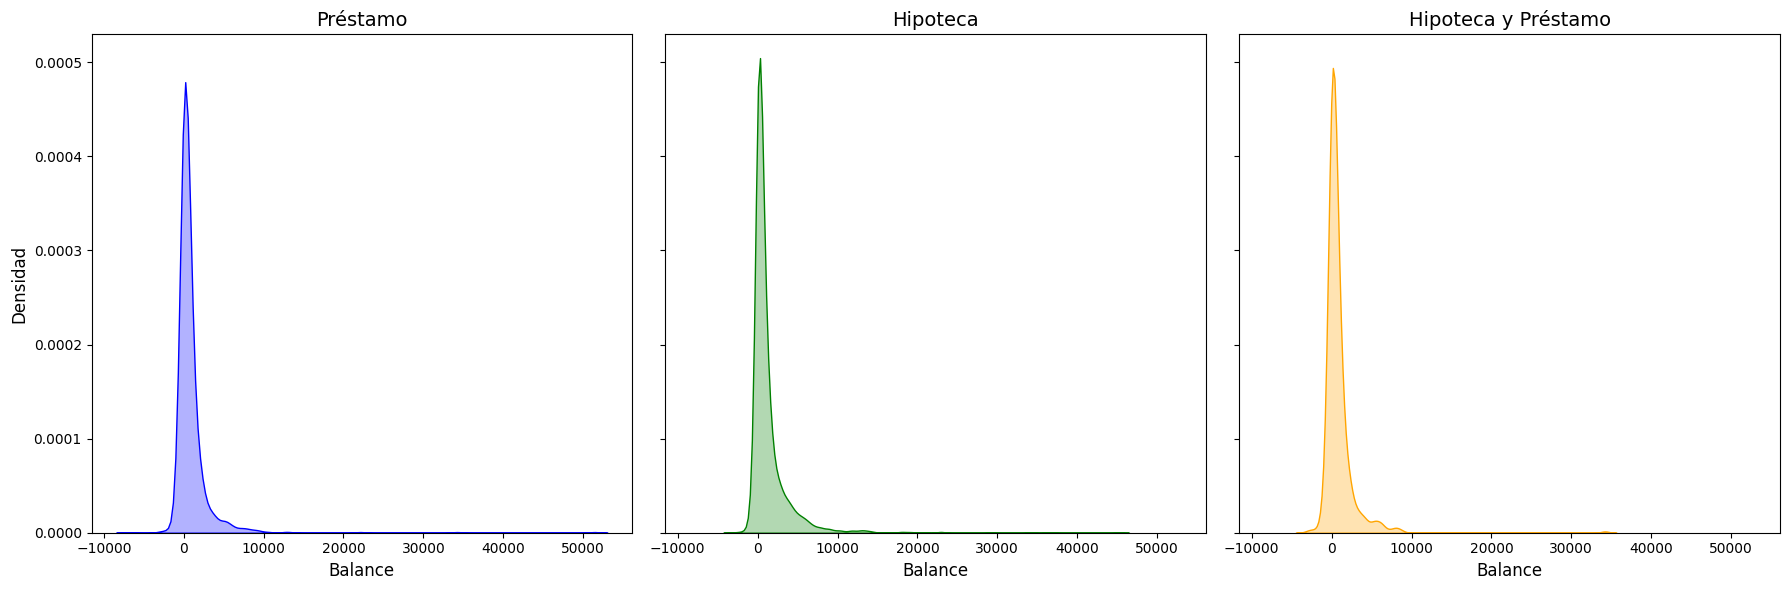

In [ ]:
# Configuración del layout para los subgráficos
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharex=True, sharey=True)

# Gráfico para Préstamo
sns.kdeplot(x=df_BANK_marketing[df_BANK_marketing['loan'] == 1]['balance'], 
            fill=True, alpha=0.3, color='blue', ax=axes[0])
axes[0].set_title('Préstamo', fontsize=14)
axes[0].set_xlabel('Balance', fontsize=12)
axes[0].set_ylabel('Densidad', fontsize=12)

# Gráfico para Hipoteca
sns.kdeplot(x=df_BANK_marketing[df_BANK_marketing['housing'] == 1]['balance'], 
            fill=True, alpha=0.3, color='green', ax=axes[1])
axes[1].set_title('Hipoteca', fontsize=14)
axes[1].set_xlabel('Balance', fontsize=12)

# Gráfico para Hipoteca y Préstamo
sns.kdeplot(x=df_BANK_marketing[(df_BANK_marketing['loan'] == 1) & (df_BANK_marketing['housing'] == 1)]['balance'], 
            fill=True, alpha=0.3, color='orange', ax=axes[2])
axes[2].set_title('Hipoteca y Préstamo', fontsize=14)
axes[2].set_xlabel('Balance', fontsize=12)

plt.tight_layout()
plt.show()




- Se observa que los balances de Préstamos, Hipotecas y la combinación de ambos tienen una fuerte tendencia a agruparse cerca de cero, con una expansión hacia valores mayores.

##### Medias de balance por categoría

C:\Users\Adam\AppData\Local\Temp\ipykernel_14696\2098734568.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Categoría', y='Media Balance', data=mean_balance_data, palette='viridis')


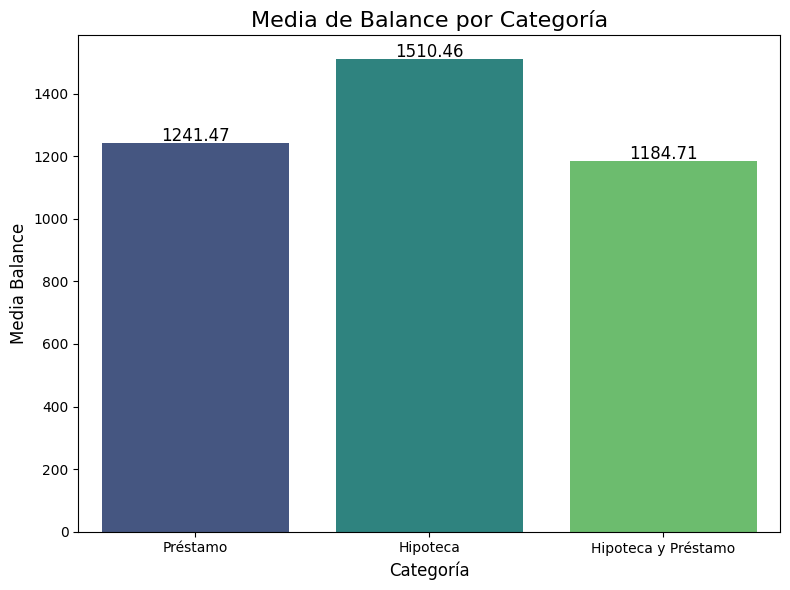

In [ ]:
# Crear el DataFrame con las medias
mean_balance_data = pd.DataFrame({
    'Categoría': ['Préstamo', 'Hipoteca', 'Hipoteca y Préstamo'],
    'Media Balance': [
        mean_balance_loan.mean(),  # Media de balance para préstamo
        mean_balance_housing.mean(),  # Media de balance para hipoteca
        mean_balance_both.mean()  # Media de balance para hipoteca y préstamo
    ]
})


plt.figure(figsize=(8, 6))
ax = sns.barplot(x='Categoría', y='Media Balance', data=mean_balance_data, palette='viridis')
# Agregar los números en las barras
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=12, color='black', xytext=(0, 5), textcoords='offset points')


plt.title('Media de Balance por Categoría', fontsize=16)
plt.xlabel('Categoría', fontsize=12)
plt.ylabel('Media Balance', fontsize=12)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

C:\Users\Adam\AppData\Local\Temp\ipykernel_14696\2544950526.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Categoría', y='Media Balance', data=mean_balance_data, palette='viridis')


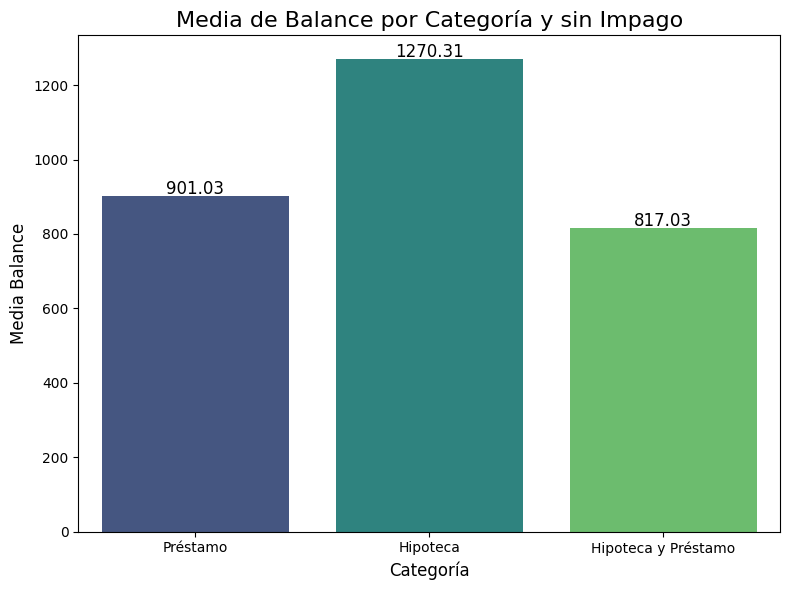

In [ ]:
# Filtrar solo clientes en default (is_in_default == 0)
df_f_default_no = df_f[df_f['is_in_default'] == 0]

# Cálculo de las medias para clientes en default
mean_balance_loan = df_f_default_no[df_f_default_no['loan'] == 1]['balance']
mean_balance_housing = df_f_default_no[df_f_default_no['housing'] == 1]['balance']
mean_balance_both = df_f_default_no[(df_f_default_no['loan'] == 1) & (df_f_default_no['housing'] == 1)]['balance']

mean_balance_data = pd.DataFrame({
    'Categoría': ['Préstamo', 'Hipoteca', 'Hipoteca y Préstamo'],
    'Media Balance': [
        mean_balance_loan.mean(),  
        mean_balance_housing.mean(), 
        mean_balance_both.mean()  
    ]
})


plt.figure(figsize=(8, 6))
ax = sns.barplot(x='Categoría', y='Media Balance', data=mean_balance_data, palette='viridis')

# Agregar los números en las barras
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}', 
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=12, color='black', 
                xytext=(0, 5), textcoords='offset points')

plt.title('Media de Balance por Categoría y sin Impago', fontsize=16)
plt.xlabel('Categoría', fontsize=12)
plt.ylabel('Media Balance', fontsize=12)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

C:\Users\Adam\AppData\Local\Temp\ipykernel_14696\2938117412.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Categoría', y='Media Balance', data=mean_balance_data, palette='viridis')


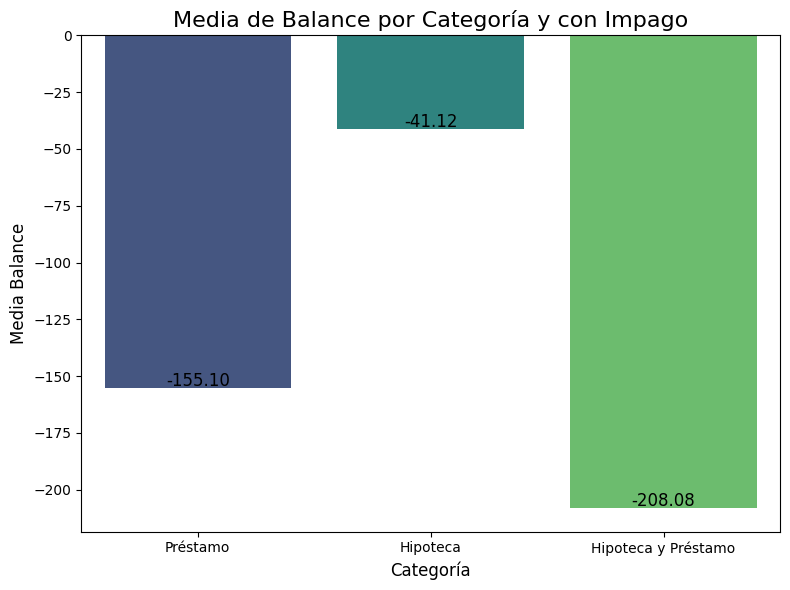

In [ ]:
# Filtrar solo clientes en default (is_in_default == 1)
df_f_default_yes = df_f[df_f['is_in_default'] == 1]

# Cálculo de las medias para clientes en default
mean_balance_loan = df_f_default_yes[df_f_default_yes['loan'] == 1]['balance']
mean_balance_housing = df_f_default_yes[df_f_default_yes['housing'] == 1]['balance']
mean_balance_both = df_f_default_yes[(df_f_default_yes['loan'] == 1) & (df_f_default_yes['housing'] == 1)]['balance']

mean_balance_data = pd.DataFrame({
    'Categoría': ['Préstamo', 'Hipoteca', 'Hipoteca y Préstamo'],
    'Media Balance': [
        mean_balance_loan.mean(),  
        mean_balance_housing.mean(), 
        mean_balance_both.mean()  
    ]
})


plt.figure(figsize=(8, 6))
ax = sns.barplot(x='Categoría', y='Media Balance', data=mean_balance_data, palette='viridis')

# Agregar los números en las barras
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}', 
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=12, color='black', 
                xytext=(0, 5), textcoords='offset points')

plt.title('Media de Balance por Categoría y con Impago', fontsize=16)
plt.xlabel('Categoría', fontsize=12)
plt.ylabel('Media Balance', fontsize=12)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


#### CONCLUSIONES

Media de Balance por Categoría:

- Los clientes con hipotecas tienen el saldo medio más alto en general y también sin impago, y muestran el menor impacto negativo en caso de impago.

- Los clientes con préstamos tienen un saldo medio inferior en comparación con los de hipotecas, con un impacto significativo en caso de impago.

- Los clientes con hipotecas y préstamos tienen el saldo medio más bajo y el mayor impacto negativo en caso de impago.
Distribución de Clientes según Préstamos:

Sin Préstamo: 98.87% sin impago y 1.13% con impago.

Con Préstamo: 95.76% sin impago y 4.24% con impago.

- Los clientes con préstamos tienen un mayor riesgo de impago en comparación con los que no tienen préstamos.

Distribución de Clientes según Hipotecas:

- Sin Hipoteca: 98.58% sin impago y 1.42% con impago.

- Con Hipoteca: 98.32% sin impago y 1.68% con impago.

- Los clientes con hipotecas tienen un riesgo ligeramente mayor de impago en comparación con los que no tienen hipotecas.

Distribución de Clientes según Hipotecas y Préstamos:

- Sin Hipoteca y Préstamo: 98.59% sin impago y 1.41% con impago.

- Con Hipoteca y Préstamo: 96.83% sin impago y 3.17% con impago.

- Los clientes con ambos productos financieros (hipoteca y préstamo) presentan un mayor riesgo de impago y un saldo medio más bajo.

Estrategias de Gestión de Riesgos y Ofertas

Clientes con Préstamos:

- Intervención Temprana: Implementar programas de asesoría financiera y asistencia.

- Consolidación de Deuda: Ofrecer productos que consoliden préstamos a tasas de interés más bajas.

Clientes con Hipotecas:

- Fidelización: Ofrecer beneficios exclusivos y programas de fidelización.

- Asesoría de Inversiones: Promover servicios de asesoría financiera.

Clientes con Hipotecas y Préstamos:

- Evaluaciones de Riesgo: Realizar evaluaciones de riesgo más estrictas y ofrecer planes de pago personalizados.

- Prevención de Impago: Desarrollar programas preventivos como recordatorios de pagos y reestructuración de deuda.
